In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download("punkt")
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import yfinance as yf
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aiden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
finviz_url = "https://finviz.com/quote.ashx?t="

tickers = ["AAPL", "BAC", "NVDA"]  # tickers of high-volume stocks

news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    res = urlopen(req)
    html = BeautifulSoup(res, "html.parser")
    news_table = html.find(id="news-table")
    news_tables[ticker] = news_table


In [3]:
parsed_data = []
total_raw_data = ""

for ticker, news_table in news_tables.items():
    allrows = news_table.find_all("tr")
    print("Getting news of " + ticker + " ...")
    for row in allrows:
        title = row.a.text
        date_data = row.td.text.split(" ")

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        text = ""
        try:
            url = row.a.get("href")
            if not url.startswith(
                (
                    "https://www.investors.com",
                    "https://www.thestreet.com",
                    "https://realmoney.thestreet.com",
                )
            ):
                # the above urls are not banned from scraping
                req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
                res = urlopen(req)
                html = BeautifulSoup(res, "html.parser")
                text = html.get_text()
                total_raw_data += text

        except Exception as e:
            print("An " + str(e) + " occurred on " + url)

        parsed_data.append([ticker, date, time, title, text])


Getting news of AAPL ...
Getting news of BAC ...
Getting news of NVDA ...


In [4]:
df = pd.DataFrame(parsed_data, columns=["ticker", "date", "time", "title", "text"])
df.describe()

,ticker,date,time,title,text
count,300,300,300,300,300
unique,3,21,233,286,278
top,AAPL,May-10-22,04:10PM,Tech stocks lose over $1 trillion in value ove...,
freq,100,42,5,2,18


In [5]:
sentences = sent_tokenize(total_raw_data)

print("Number of sentences: " + str(len(sentences)))


Number of sentences: 16158


In [6]:
words_in_sentences = [
    RegexpTokenizer(r"\w+").tokenize(sentence) for sentence in sentences
]

print(
    "Number of words in sentences: "
    + str(sum([len(sentence) for sentence in words_in_sentences]))
)


Number of words in sentences: 696405


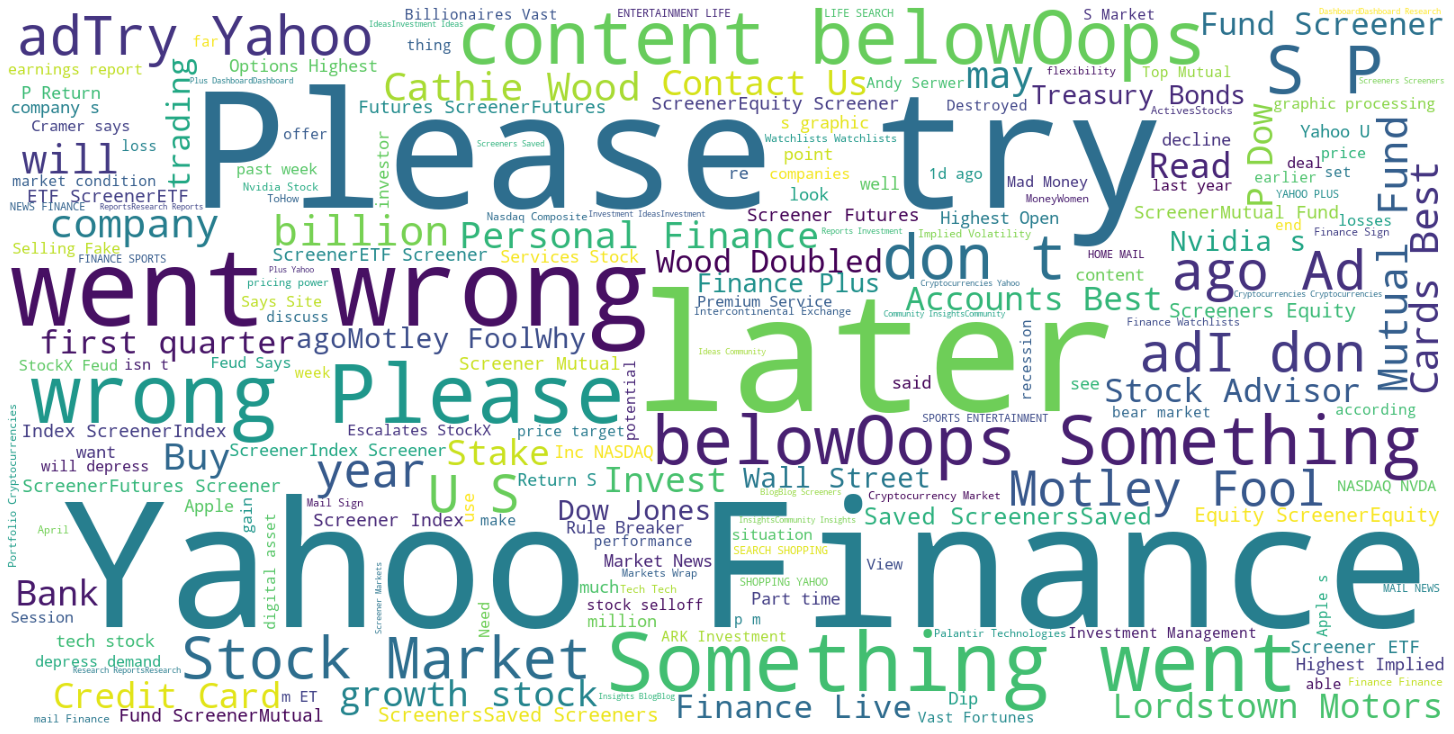

In [7]:
all_words = ' '.join(RegexpTokenizer(r"\w+").tokenize(total_raw_data))
cloud = WordCloud(width=1600, height=800,background_color='white').generate(all_words)
plt.figure( figsize=(20,10))
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<Figure size 1152x648 with 0 Axes>

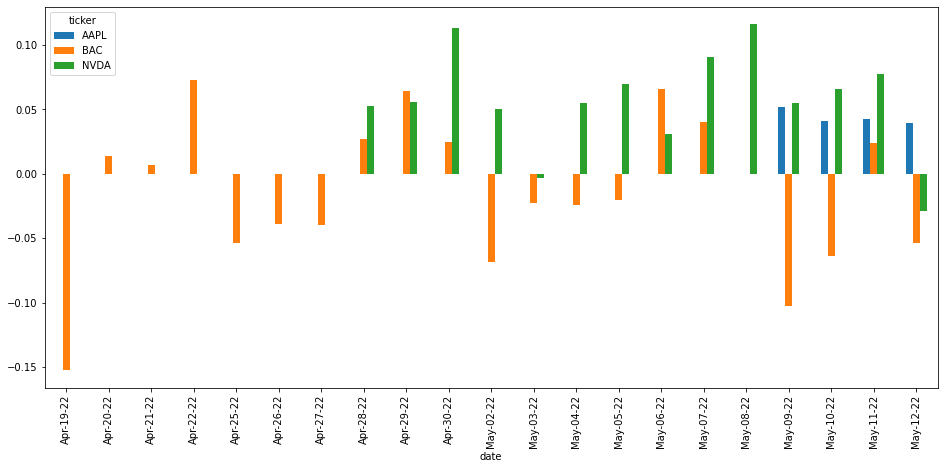

In [8]:
vader = SentimentIntensityAnalyzer()

# compound is not suitable for this case
def analyze(text):
    pos = vader.polarity_scores(text)["pos"]
    neg = vader.polarity_scores(text)["neg"]
    return pos - neg


df["score"] = df["text"].apply(analyze)
df["date"] == pd.to_datetime(df.date).dt.date


plt.figure(figsize=(16, 9))
plt.rcParams["figure.figsize"] = [16, 7]

mean_df = df.groupby(["ticker", "date"]).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs("score", axis="columns").transpose()
mean_df.plot(kind="bar")
plt.show()


In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
def price_change(ticker,date):
    tickerData = yf.Ticker(ticker)
    open = tickerData.history(period='1d', start=date, end=date)['Open']
    close = tickerData.history(period='1d', start=date, end=date)['Close']
    return close - open
for ticker in tickers:
    first_date,last_date = min(df['date']),max(df['date'])
    tickerData = yf.Ticker(ticker)
    history = tickerData.history(period='1d', start=first_date, end=last_date)
    mean_df[ ticker + '_price_change' ] = history['Close'] - history['Open']


<AxesSubplot:xlabel='ticker', ylabel='ticker'>

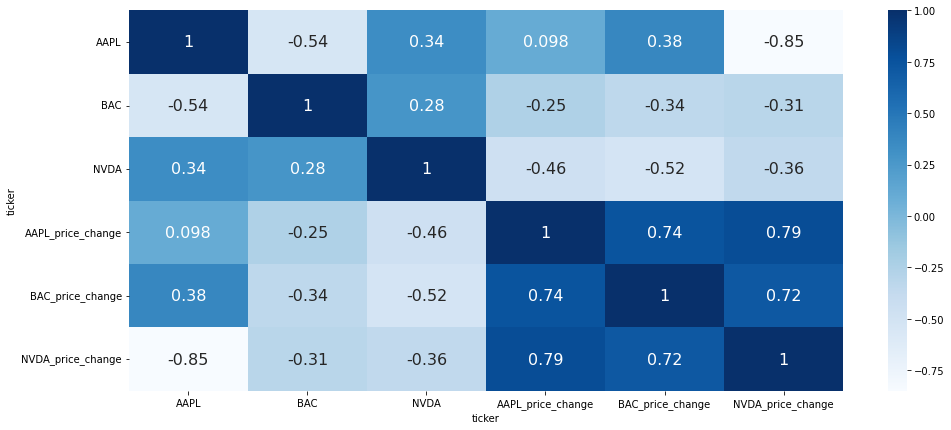

In [11]:
sns.heatmap(mean_df.corr(), cmap="Blues", annot=True,annot_kws={'size': 16})